# End-to-end walkthrough: credit scoring pipeline

Эта тетрадь пошагово повторяет действующий пайплайн скора, опираясь только на готовые функции проекта: от загрузки данных до explainability артефактов.

## План
1. Настройка окружения и импорт модулей.
2. Разбор `configs/default.yaml` и ключевых гиперпараметров.
3. Ingest + master-table и первичный EDA.
4. Временной сплит train/valid/OOT.
5. Feature engineering (`build_features`) и визуализации.
6. Подготовка матриц X/y и отбор признаков.
7. Обучение Champion/Challenger моделей.
8. Метрики качества + ROC/PR/калибровка/лифт.
9. Explainability: коэффициенты, reason codes, SHAP/feature importance.

In [5]:
import os
import sys
import json
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "configs").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "configs").exists():
            PROJECT_ROOT = parent
            break
    else:
        raise RuntimeError("Не удалось найти корень проекта с папкой configs/")
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import load_config, seed_everything
from src.data_loading import load_master_dataset, build_credit_history_features
from src.modeling import (
    split_by_time,
    train_logistic_woe,
    train_catboost,
    train_lgbm,
)
from scripts.train import (
    _augment_with_features,
    _select_feature_columns,
    _align_frames,
    _run_feature_diagnostics,
    _drop_sensitive,
)
from src.metrics import (
    compute_metrics,
    report_to_dict,
    reliability_curve,
    lift_curve,
)
from src.explainability import champion_coefficients
from sklearn.metrics import roc_curve, precision_recall_curve

pd.options.display.max_columns = 120
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-v0_8")
print(f"Проект: {PROJECT_ROOT}")

Проект: /home/zerotwo/ml-coding-hack


## Шаг 2. Конфигурация пайплайна
Разбираем `configs/default.yaml`: источники данных, таргет, временные границы, параметры feature engineering и моделей.

In [6]:
config_path = PROJECT_ROOT / "configs" / "default.yaml"
config = load_config(config_path)
seed_everything(config.get("seed", 42))
print(f"Используем конфиг: {config_path}")

sections = {
    "paths": config.get("paths", {}),
    "data_sources": config.get("data_sources", {}),
    "target": config.get("target", {}),
    "split": config.get("split", {}),
    "feature_engineering": config.get("feature_engineering", {}),
    "modeling": config.get("modeling", {}),
    "feature_selection": config.get("feature_selection", {}),
    "calibration": config.get("calibration", {}),
}
for name, payload in sections.items():
    print("====", name.upper(), "====")
    print(yaml.safe_dump(payload, sort_keys=False, allow_unicode=True))

artifacts_dir = (PROJECT_ROOT / config["paths"]["artifacts_dir"]).resolve()
models_dir = (PROJECT_ROOT / config["paths"]["models_dir"]).resolve()
artifacts_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

Используем конфиг: /home/zerotwo/ml-coding-hack/configs/default.yaml
==== PATHS ====
data_dir: data/ml_coding_hackathon
artifacts_dir: artifacts
models_dir: models
reports_dir: artifacts/reports
inventory_report: artifacts/data_inventory.json
master_table: artifacts/master_table.parquet

==== DATA_SOURCES ====
application: application_metadata.csv
demographics: demographics.csv
loan_details: loan_details.xlsx
financial_ratios: financial_ratios.jsonl
credit_history: credit_history.parquet

==== TARGET ====
column: default
positive_label: 1
observation_window_months: 12
performance_window_months: 12

==== SPLIT ====
date_column: application_date
train_end: '2021-12-31'
valid_end: '2022-12-31'
client_id_col: customer_ref
application_id_col: application_id

==== FEATURE_ENGINEERING ====
ratios:
  dti:
  - total_debt_amount
  - monthly_income
  utilization:
  - credit_usage_amount
  - available_credit
  payment_rate:
  - monthly_payment
  - monthly_income
  loan_to_income:
  - loan_amount
 

## Шаг 3. Ingest и master-table
Построим master-table из всех источников, добавим агрегаты по кредитной истории и посмотрим базовый EDA: размеры, head(), таргет, пропуски и распределения.

Master-table после мерджа справочников: (89999, 46)
Добавили агрегаты кредитной истории: (89999, 80)
После фильтра по default/application_date: (89999, 80)


,customer_ref,application_id,application_hour,application_day_of_week,account_open_year,preferred_contact,referral_code,account_status_code,random_noise_1,num_login_sessions,num_customer_service_calls,has_mobile_app,paperless_billing,default,application_date,age,annual_income,employment_length,employment_type,education,marital_status,num_dependents,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,loan_officer_id,marketing_campaign,monthly_income,existing_monthly_debt,monthly_payment,debt_to_income_ratio,debt_service_ratio,payment_to_income_ratio,credit_utilization,revolving_balance,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow,credit_score_mean_hist,credit_score_max_hist,credit_score_min_hist,num_credit_accounts_mean_hist,num_credit_accounts_max_hist,num_credit_accounts_min_hist,oldest_credit_line_age_mean_hist,oldest_credit_line_age_max_hist,oldest_credit_line_age_min_hist,oldest_account_age_months_mean_hist,oldest_account_age_months_max_hist,oldest_account_age_months_min_hist,total_credit_limit_mean_hist,total_credit_limit_max_hist,total_credit_limit_min_hist,num_delinquencies_2yrs_mean_hist,num_delinquencies_2yrs_max_hist,num_delinquencies_2yrs_min_hist,num_inquiries_6mo_mean_hist,num_inquiries_6mo_max_hist,num_inquiries_6mo_min_hist,recent_inquiry_count_mean_hist,recent_inquiry_count_max_hist,recent_inquiry_count_min_hist,num_public_records_mean_hist,num_public_records_max_hist,num_public_records_min_hist,num_collections_mean_hist,num_collections_max_hist,num_collections_min_hist,account_diversity_index_mean_hist,account_diversity_index_max_hist,account_diversity_index_min_hist,credit_history_records
0,69404,605065,11,0,2010,Phone,REF4360,ACT-1,0.060217,6,2,1,1,0,2010-06-30,45,31800,3.8,Full-time,Bachelor,Divorced,2,CreditCard,1700,0,17.95,Revolving Credit,0.000,Broker,1068,G,2650.00,399.55,51.00,0.170,0.170019,0.019,0.491,23911.7,23911.7,24788.3,450.55,5406.60,0.053459,25611.7,2199.450000,693.0,693,693,6.0,6,6,18.0,18.0,18.0,216.0,216.0,216.0,48700.0,48700.0,48700.0,0.0,0.0,0.0,2.0,2,2,2.0,2,2,0.0,0,0,0.0,0,0,0.447,0.447,0.447,1
1,71676,586853,10,5,2010,Email,REF0000,ACT-3,0.925186,4,1,1,1,0,2010-06-30,21,20000,2.2,Full Time,Graduate,Single,1,Home Loan,231400,180,6.78,Home Purchase,0.908,Online,1049,T,1667.00,206.82,2051.53,1.355,1.355010,1.231,0.299,12737.4,12737.4,29862.6,2258.35,27100.20,11.570000,244137.4,-591.683333,688.0,688,688,2.0,2,2,3.0,3.0,3.0,36.0,36.0,36.0,42600.0,42600.0,42600.0,0.0,0.0,0.0,1.0,1,1,1.0,1,1,0.0,0,0,0.0,0,0,0.147,0.147,0.147,1
2,15801,629606,12,1,2010,Phone,REF1109,ACT-3,-0.050595,9,2,0,0,0,2010-06-30,49,68800,4.7,Self Employed,High School,Married,2,Personal Loan,2000,48,10.07,Home Improvement,0.000,Online,1055,K,5733.33,566.59,50.79,0.108,0.107683,0.009,0.355,77425.5,77425.5,140674.5,617.38,7408.56,0.029070,79425.5,5115.953333,755.0,755,755,6.0,6,6,16.6,16.6,16.6,199.2,199.2,199.2,218100.0,218100.0,218100.0,0.0,0.0,0.0,2.0,2,2,2.0,2,2,0.0,0,0,0.0,0,0,0.385,0.385,0.385,1
3,44764,548091,9,2,2010,Mail,REF0000,A01,1.653185,4,2,1,1,1,2010-06-30,20,23400,2.4,FT,Some College,Single,1,Personal Loan,31200,36,16.43,Other,0.000,Branch,1079,E,1950.00,142.07,1103.53,0.639,0.638769,0.566,0.763,15794.1,15794.1,4905.9,1245.60,14947.20,1.333333,46994.1,704.400000,656.0,656,656,11.0,11,11,2.0,2.0,2.0,24.0,24.0,24.0,20700.0,20700.0,20700.0,0.0,0.0,0.0,1.0,1,1,1.0,1,1,0.0,0,0,0.0,0,0,0.329,0.329,0.329,1
4,88630,587880,6,0,2010,Email,REF0000,ACT-1,0.749899,8,4,1,1,0,2010-06-30,31,38300,7.6,Part-time,Bachelor,Married,2,mortgage,228100,360,7.90,Refinance,0.784,Online,1091,Q,3191.67,852.45,1657.84,0.787,0.786514,0.519,0.767,26231.4,26231.4,7968.6,2510.29,30123.48,5.955614,254331.4,681.380000,730.0,730,730,10.0,10,10,13.0,13.0,13.0,156.0,156.0,156.0,34200.0,34200.0,34200.0,0.0,0.0,0.0,1.0,1,1,1.0,1,1,0.0,0,0,0.0,0,0,0.318,0.318,0.318,1


Распределение таргета (count/share):


,count,share
default,,
0,85405,0.948955
1,4594,0.051045


,missing_rows
customer_ref,0
application_id,0
default,0
application_date,0
loan_amount,0
annual_income,0
credit_utilization,0
debt_to_income_ratio,0


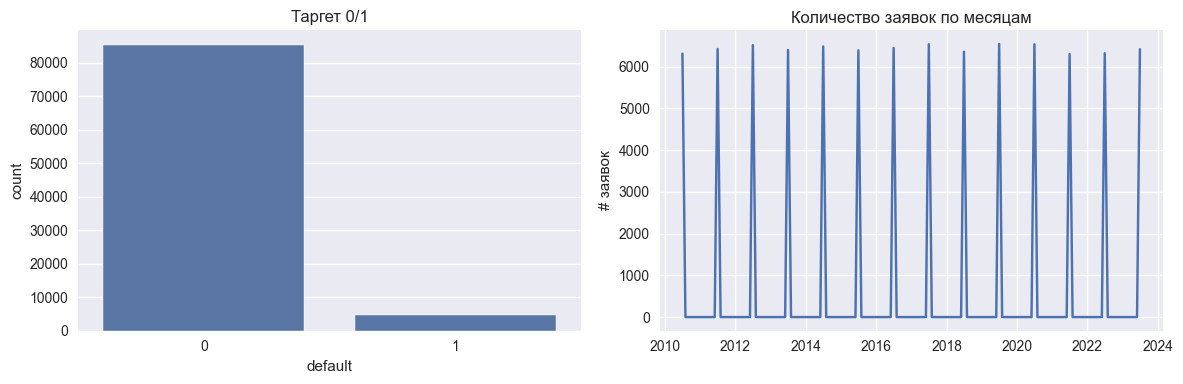

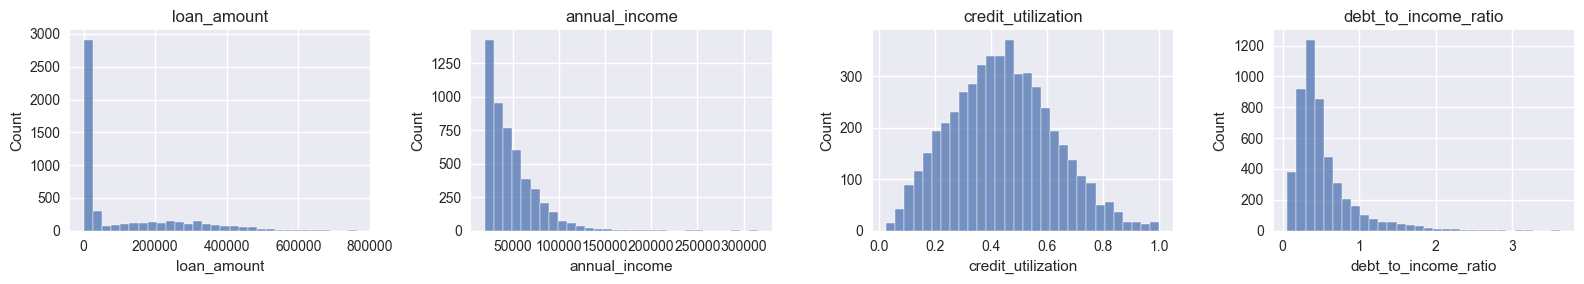

In [7]:
target_col = config["target"]["column"]
date_col = config["split"]["date_column"]
id_col = config.get("merging", {}).get("id_col", "customer_ref")
app_col = config["split"].get("application_id_col", "application_id")

master_df, credit_history = load_master_dataset(config)
print(f"Master-table после мерджа справочников: {master_df.shape}")
if credit_history is not None and not credit_history.empty:
    credit_features = build_credit_history_features(credit_history, master_df, config)
    master_df = master_df.merge(credit_features, on=app_col, how="left")
    print(f"Добавили агрегаты кредитной истории: {master_df.shape}")

master_df[date_col] = pd.to_datetime(master_df[date_col], errors="coerce")
master_df = master_df.dropna(subset=[target_col, date_col]).sort_values(date_col).reset_index(drop=True)
print(f"После фильтра по {target_col}/{date_col}: {master_df.shape}")

display(master_df.head())

print("Распределение таргета (count/share):")
target_stats = master_df[target_col].value_counts(dropna=False).to_frame("count")
target_stats["share"] = target_stats["count"] / len(master_df)
display(target_stats)

key_cols = [id_col, app_col, target_col, date_col, "loan_amount", "annual_income", "credit_utilization", "debt_to_income_ratio"]
missing_info = {
    col: int(master_df[col].isna().sum())
    for col in key_cols
    if col in master_df.columns
}
display(pd.DataFrame.from_dict(missing_info, orient="index", columns=["missing_rows"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=target_col, data=master_df, ax=axes[0])
axes[0].set_title("Таргет 0/1")
axes[0].set_xlabel("default")
monthly = master_df.set_index(date_col).resample("M").size()
axes[1].plot(monthly.index, monthly.values)
axes[1].set_title("Количество заявок по месяцам")
axes[1].set_ylabel("# заявок")
plt.tight_layout()
plt.show()

feature_candidates = ["loan_amount", "annual_income", "credit_utilization", "debt_to_income_ratio"]
available = [col for col in feature_candidates if col in master_df.columns]
if available:
    sample = master_df[available].sample(min(len(master_df), 5000), random_state=42)
    fig, axes = plt.subplots(1, len(available), figsize=(4 * len(available), 3))
    if len(available) == 1:
        axes = [axes]
    for ax, col in zip(axes, available):
        sns.histplot(sample[col], bins=30, ax=ax, kde=False)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()

## Шаг 4. Временной сплит
Используем `split_by_time` из `src.modeling` и границы из конфига, чтобы получить train/valid/OOT. Проверим размеры, диапазоны дат и долю дефолтов для каждого среза.

In [8]:
train_end = config["split"]["train_end"]
valid_end = config["split"]["valid_end"]
raw_splits = split_by_time(master_df, date_col, train_end, valid_end)

summary = []
for name, frame in raw_splits.items():
    if frame.empty:
        continue
    date_range = frame[date_col].agg(["min", "max"])
    summary.append(
        {
            "split": name,
            "rows": len(frame),
            "date_start": date_range["min"],
            "date_end": date_range["max"],
            "default_rate": frame[target_col].mean(),
        }
    )
display(pd.DataFrame(summary))

,split,rows,date_start,date_end,default_rate
0,train,77259,2010-06-30,2021-06-30,0.051101
1,valid,6322,2022-06-30,2022-06-30,0.054413
2,oot,6418,2023-06-30,2023-06-30,0.047055


## Шаг 5. Feature engineering
Воспользуемся `_augment_with_features`, который внутри вызывает `build_features` и добавляет ratio/rolling/trend/behavioral признаки. Покажем, сколько новых фич появилось и как они распределены.

2025-11-16 04:04:42,361 | INFO | src.feature_eng | Generated 248 engineered features
2025-11-16 04:05:06,036 | INFO | src.feature_eng | Generated 248 engineered features
2025-11-16 04:05:30,459 | INFO | src.feature_eng | Generated 248 engineered features


,split,rows,baseline_cols,engineered_cols,total_cols
0,train,77259,80,247,327
1,valid,6322,80,247,327
2,oot,6418,80,247,327


Новых признаков в train: 247


,dti,utilization,payment_rate,loan_to_income,payment_to_income,behavior_dti,monthly_payment_mean_by_customer_ref,monthly_payment_max_by_customer_ref,loan_amount_mean_by_customer_ref,loan_amount_max_by_customer_ref
0,9.664792,0.964637,0.019245,0.053459,0.001604,0.170019,51.00,51.00,1700.0,1700
1,146.453149,0.426534,1.230672,11.570000,0.102577,1.354739,2051.53,2051.53,231400.0,231400
2,13.853293,0.550388,0.008859,0.029070,0.000738,0.107683,50.79,50.79,2000.0,2000
3,24.099538,3.219409,0.565913,1.333333,0.047159,0.638769,1103.53,1103.53,31200.0,31200
4,79.685995,3.291845,0.519427,5.955614,0.043286,0.786513,1657.84,1657.84,228100.0,228100


,count,mean,std,min,25%,50%,75%,max
dti,77259.0,44.424809,55.722021,0.586375,11.357973,18.802065,57.809076,461.295981
utilization,77141.0,1.249045,6.890352,0.013171,0.440922,0.763668,1.298851,999.000000
payment_rate,77259.0,0.305301,0.365791,0.001676,0.076991,0.168641,0.383119,4.525605
loan_to_income,77259.0,2.871447,4.620953,0.004655,0.218502,0.511745,3.978652,38.127451
payment_to_income,77259.0,0.025442,0.030483,0.000140,0.006416,0.014053,0.031928,0.377134
behavior_dti,77259.0,0.530806,0.379735,0.054046,0.295867,0.423039,0.626794,4.630473
monthly_payment_mean_by_customer_ref,77259.0,926.723758,892.202141,15.000000,294.000000,565.220000,1321.230000,7542.690000
monthly_payment_max_by_customer_ref,77259.0,926.723758,892.202141,15.000000,294.000000,565.220000,1321.230000,7542.690000


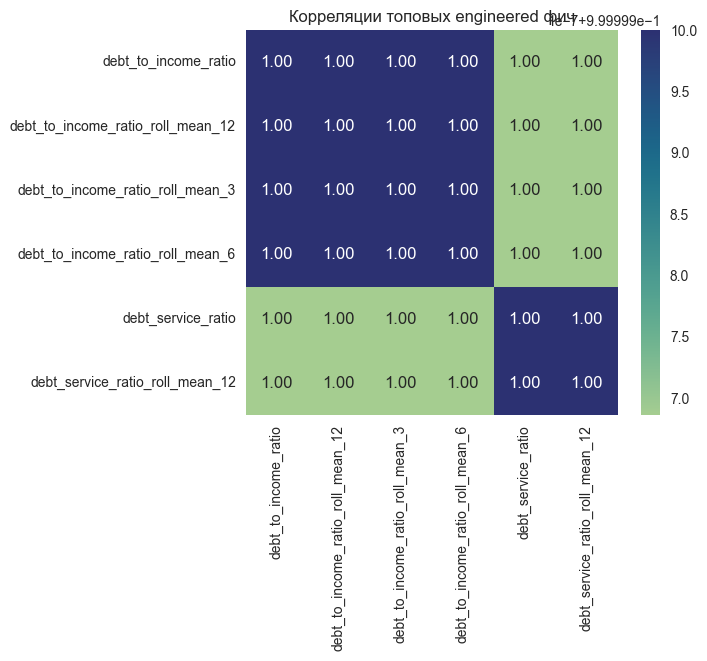

In [9]:
feature_cfg = config.get("feature_engineering", {})
client_id_col = config["split"].get("client_id_col")
MAX_ROWS_PER_SPLIT = None  # при необходимости можно ограничить размер срезов для быстрой отладки

processed_splits = {}
for name, frame in raw_splits.items():
    subset = frame.copy()
    if MAX_ROWS_PER_SPLIT:
        subset = subset.iloc[: min(MAX_ROWS_PER_SPLIT, len(subset))].copy()
    processed_splits[name] = subset

augmented_splits = {}
feature_stats = []
for name, frame in processed_splits.items():
    augmented = _augment_with_features(frame, feature_cfg, date_col, client_id_col)
    augmented_splits[name] = augmented
    engineered_cols = [col for col in augmented.columns if col not in frame.columns]
    feature_stats.append(
        {
            "split": name,
            "rows": len(augmented),
            "baseline_cols": len(frame.columns),
            "engineered_cols": len(engineered_cols),
            "total_cols": len(augmented.columns),
        }
    )
display(pd.DataFrame(feature_stats))

train_engineered = [col for col in augmented_splits["train"].columns if col not in raw_splits["train"].columns]
print(f"Новых признаков в train: {len(train_engineered)}")
display(augmented_splits["train"][train_engineered[:10]].head())

stat_cols = train_engineered[:8]
if stat_cols:
    display(augmented_splits["train"][stat_cols].describe().T)

feature_strength_path = artifacts_dir / "feature_strength.json"
feature_strength = {}
if feature_strength_path.exists():
    with open(feature_strength_path, "r", encoding="utf-8") as fh:
        feature_strength = json.load(fh)
    top_auc_cols = [item["feature"] for item in feature_strength.get("top_auc", []) if item["feature"] in augmented_splits["train"].columns][:6]
else:
    top_auc_cols = train_engineered[:6]

if top_auc_cols:
    corr_sample = augmented_splits["train"][top_auc_cols].sample(min(len(augmented_splits["train"]), 5000), random_state=42)
    corr = corr_sample.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="crest", fmt=".2f")
    plt.title("Корреляции топовых engineered фич")
    plt.show()

## Шаг 6. Матрицы X/y и отбор фич
Повторяем продакшн-логику: фильтруем потенциально утечные признаки, выравниваем срезы, запускаем `_run_feature_diagnostics`, убираем подозрительные и чувствительные столбцы.

In [10]:
id_like = config.get("merging", {}).get("id_like_cols", [])
forbidden_ids = [col for col in [id_col, app_col] if col]
forbidden_ids.extend([col for col in id_like if col])
forbidden_ids = list(dict.fromkeys(forbidden_ids))

safe_columns = _select_feature_columns(augmented_splits, target_col, date_col, forbidden_ids)
aligned_splits = _align_frames(augmented_splits, safe_columns)

diagnostics = _run_feature_diagnostics(
    aligned_splits["train"],
    aligned_splits["valid"],
    target_col,
    date_col,
    artifacts_dir,
    config.get("feature_selection", {}),
)
drop_candidates = diagnostics.get("drop_columns", [])
if drop_candidates:
    for name in aligned_splits:
        aligned_splits[name] = aligned_splits[name].drop(columns=drop_candidates, errors="ignore")

sensitive_cols = config.get("fairness", {}).get("sensitive_cols", [])
if sensitive_cols:
    for name in aligned_splits:
        aligned_splits[name] = _drop_sensitive(aligned_splits[name], sensitive_cols)

train_df = aligned_splits["train"].copy()
valid_df = aligned_splits["valid"].copy()
oot_df = aligned_splits["oot"].copy()

model_features = [col for col in train_df.columns if col != target_col]
print(f"Финальный train shape: {train_df.shape}, число фич без таргета: {len(model_features)}")

if feature_strength:
    top_auc = pd.DataFrame(feature_strength.get("top_auc", [])[:10])
    display(top_auc)

print("Диагностика single-feature:")
print(json.dumps({k: diagnostics.get(k) for k in ["suspicious", "low_variance", "weak_auc"]}, indent=2)[:1000])

Финальный train shape: (77259, 159), число фич без таргета: 158


,feature,auc_train,auc_valid,corr,unique_ratio
0,debt_to_income_ratio,0.698355,0.691310,0.220086,0.031453
1,debt_to_income_ratio_roll_mean_12,0.698355,0.691310,0.220086,0.031453
2,debt_to_income_ratio_roll_mean_3,0.698355,0.691310,0.220086,0.031453
3,debt_to_income_ratio_roll_mean_6,0.698355,0.691310,0.220086,0.031453
4,debt_service_ratio,0.698355,0.691319,0.220084,0.997101
5,debt_service_ratio_roll_mean_12,0.698355,0.691319,0.220084,0.997101
6,debt_service_ratio_roll_mean_3,0.698355,0.691319,0.220084,0.997101
7,debt_service_ratio_roll_mean_6,0.698355,0.691319,0.220084,0.997101
8,behavior_dti,0.698351,0.691317,0.220079,0.998706
9,payment_to_income,0.697113,0.687157,0.220279,0.930688


Диагностика single-feature:
{
  "suspicious": [
    "application_id_roll_mean_12",
    "application_id_roll_mean_3",
    "application_id_roll_mean_6",
    "random_noise_1",
    "random_noise_1_roll_mean_12",
    "random_noise_1_roll_mean_3",
    "random_noise_1_roll_mean_6"
  ],
  "low_variance": null,
  "weak_auc": null
}


## Шаг 7. Champion / Challenger
Обучаем логистическую регрессию с WOE (champion) и деревья (CatBoost, LightGBM) теми же функциями, что и продакшн. Сравниваем валидационные метрики.

In [12]:
model_cfg = config.get("modeling", {})
cv_folds = model_cfg.get("cv_folds", 1)
group_col = client_id_col if client_id_col and client_id_col in train_df.columns else None

champion_model = train_logistic_woe(train_df, valid_df, target_col, model_cfg.get("logistic", {}))
cat_model = train_catboost(
    train_df,
    valid_df,
    target_col,
    model_cfg.get("catboost", {}),
    date_col,
    group_col,
    cv_folds,
)
lgbm_model = train_lgbm(
    train_df,
    valid_df,
    target_col,
    model_cfg.get("lightgbm", {}),
    date_col,
    group_col,
    cv_folds,
)

trained_models = [m for m in [champion_model, cat_model, lgbm_model] if m is not None]
metrics_table = pd.DataFrame(
    [
        {"model": m.name, **m.metrics}
        for m in trained_models
    ]
)
display(metrics_table)

challengers = [m for m in trained_models if m.name != "logistic_woe"]
best_challenger = max(challengers, key=lambda m: m.metrics.get("roc_auc", 0.0)) if challengers else None
if best_challenger:
    print(f"Лучший challenger: {best_challenger.name} (ROC-AUC={best_challenger.metrics['roc_auc']:.4f})")
else:
    print("Челленджеры недоступны (catboost/lightgbm не установлены)")

/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = encoded.astype(float)
/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = encoded.astype(float)
/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

,model,roc_auc,gini,pr_auc,ks,logloss,brier,ece,sanity_shuffled_auc,is_suspicious,cv_roc_auc_mean
0,logistic_woe,0.715250,0.430500,0.117448,0.338245,0.628471,0.216630,0.383174,NaN,NaN,NaN
1,catboost,0.775022,0.550045,0.219749,0.440453,0.533607,0.177366,0.320560,0.418999,False,0.792047
2,lightgbm,0.753772,0.507544,0.194198,0.375396,0.244458,0.068981,0.073966,0.445450,False,0.749303


Лучший challenger: catboost (ROC-AUC=0.7750)


## Шаг 8. Метрики и визуализации
Считаем ROC/PR/калибровку/лифт по champion и лучшему challenger (если он есть). Параллельно загружаем готовые `artifacts/metrics.json`, чтобы сравнить с тренировочным пайплайном.

/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = encoded.astype(float)
/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = encoded.astype(float)
/home/zerotwo/ml-coding-hack/src/woe_iv.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

,model,valid_roc_auc,valid_gini,valid_pr_auc,valid_ks,valid_logloss,valid_brier,valid_ece,oot_roc_auc,oot_gini,oot_pr_auc,oot_ks,oot_logloss,oot_brier,oot_ece
0,logistic_woe,0.715250,0.430500,0.117448,0.338245,0.628471,0.216630,0.383174,0.712878,0.425756,0.097941,0.338919,0.623107,0.214483,0.387626
1,catboost,0.775022,0.550045,0.219749,0.440453,0.533607,0.177366,0.320560,0.790351,0.580702,0.203066,0.442664,0.528481,0.175935,0.324955
2,lightgbm,0.753772,0.507544,0.194198,0.375396,0.244458,0.068981,0.073966,0.757308,0.514616,0.169705,0.390790,0.229912,0.065828,0.078962


Метрики, сохранённые train-пайплайном:


{'champion': {'roc_auc': 0.7145947446839964,
  'gini': 0.42918948936799284,
  'pr_auc': 0.11594581506676498,
  'ks': 0.33920790962210273,
  'logloss': 0.6287066895186091,
  'brier': 0.21671902695130135,
  'ece': 0.3832510220192009},
 'challenger': {'roc_auc': 0.7750224660966178,
  'gini': 0.5500449321932357,
  'pr_auc': 0.2197492222072724,
  'ks': 0.4404531732632054,
  'logloss': 0.5336070991201339,
  'brier': 0.17736601315311779,
  'ece': 0.32055993433590374,
  'sanity_shuffled_auc': 0.4189985372723241,
  'is_suspicious': False,
  'cv_roc_auc_mean': 0.7920468312301812},
 'calibration': {'platt_brier': 0.047223070257250775,
  'isotonic_brier': 0.04633414220280611},
 'valid': {'roc_auc': 0.7815553833046753,
  'gini': 0.5631107666093507,
  'pr_auc': 0.21396291818889526,
  'ks': 0.44731165436056236,
  'logloss': 0.17889069601071847,
  'brier': 0.04633414220280611,
  'ece': 2.0810096238228574e-18},
 'oot': {'roc_auc': 0.7868128435240971,
  'gini': 0.5736256870481942,
  'pr_auc': 0.17882266

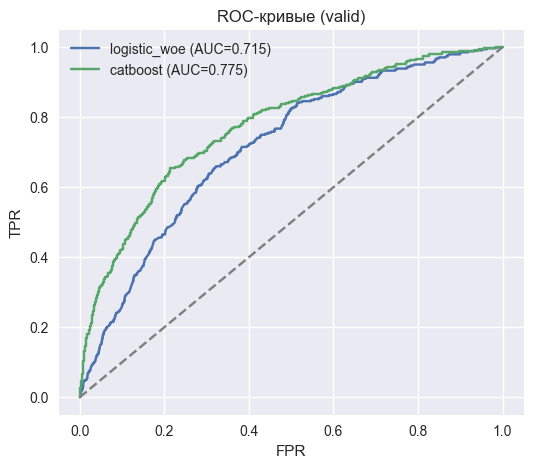

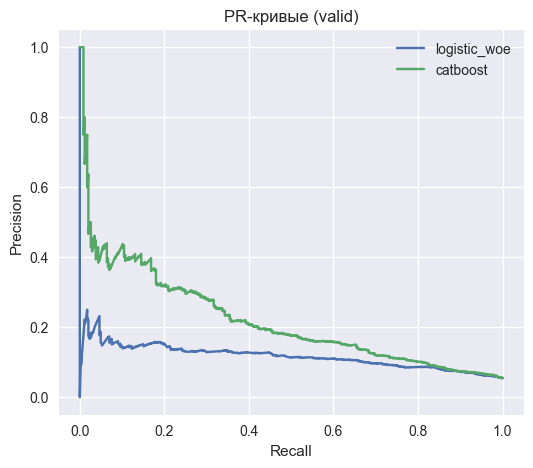

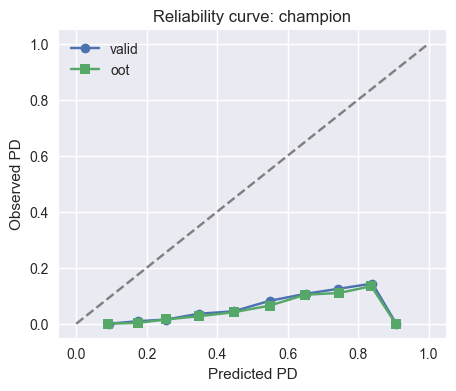

,decile,lift,gain
0,1,2.442588,0.132911
1,2,2.253579,0.122627
2,3,2.016105,0.109705
3,4,1.773784,0.096519
4,5,1.581867,0.086076
5,6,1.434536,0.078059
6,7,1.304375,0.070976
7,8,1.188581,0.064676
8,9,1.088826,0.059248
9,10,1.000298,0.054430


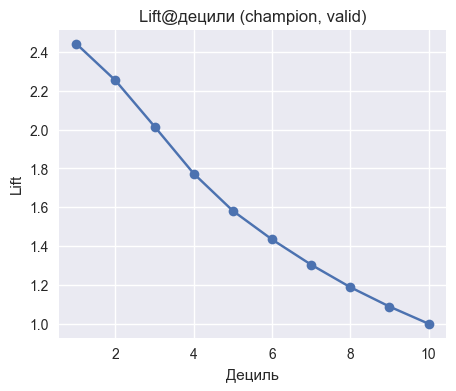

In [13]:
valid_y = valid_df[target_col].values
oot_y = oot_df[target_col].values

predictions = {}
eval_rows = []
for model in trained_models:
    valid_pred = model.predict_proba(valid_df)
    oot_pred = model.predict_proba(oot_df)
    predictions[model.name] = {"valid": valid_pred, "oot": oot_pred}
    valid_report = report_to_dict(compute_metrics(valid_y, valid_pred))
    oot_report = report_to_dict(compute_metrics(oot_y, oot_pred))
    eval_rows.append({"model": model.name, **{f"valid_{k}": v for k, v in valid_report.items()}, **{f"oot_{k}": v for k, v in oot_report.items()}})

eval_df = pd.DataFrame(eval_rows)
display(eval_df)

metrics_path = artifacts_dir / "metrics.json"
if metrics_path.exists():
    with open(metrics_path, "r", encoding="utf-8") as fh:
        stored_metrics = json.load(fh)
    print("Метрики, сохранённые train-пайплайном:")
    display(stored_metrics)

plot_models = [champion_model.name]
if best_challenger is not None:
    plot_models.append(best_challenger.name)

plt.figure(figsize=(6, 5))
for name in plot_models:
    fpr, tpr, _ = roc_curve(valid_y, predictions[name]["valid"])
    auc_value = eval_df.loc[eval_df["model"] == name, "valid_roc_auc"].values[0]
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC-кривые (valid)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for name in plot_models:
    precision, recall, _ = precision_recall_curve(valid_y, predictions[name]["valid"])
    plt.plot(recall, precision, label=name)
plt.title("PR-кривые (valid)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

champ_name = champion_model.name
rel_valid = reliability_curve(valid_y, predictions[champ_name]["valid"], n_bins=10)
rel_oot = reliability_curve(oot_y, predictions[champ_name]["oot"], n_bins=10)
plt.figure(figsize=(5, 4))
plt.plot(rel_valid["pred"], rel_valid["true"], marker="o", label="valid")
plt.plot(rel_oot["pred"], rel_oot["true"], marker="s", label="oot")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Reliability curve: champion")
plt.xlabel("Predicted PD")
plt.ylabel("Observed PD")
plt.legend()
plt.show()

lift_valid = lift_curve(valid_y, predictions[champ_name]["valid"], n_bins=10)
lift_df = pd.DataFrame({"decile": range(1, len(lift_valid["lift"]) + 1), "lift": lift_valid["lift"], "gain": lift_valid["gain"]})
display(lift_df.head(10))
plt.figure(figsize=(5, 4))
plt.plot(lift_df["decile"], lift_df["lift"], marker="o")
plt.title("Lift@децили (champion, valid)")
plt.xlabel("Дециль")
plt.ylabel("Lift")
plt.show()

## Шаг 9. Explainability
Используем готовые инструменты: коэффициенты champion (и reason codes из артефакта), а также SHAP/feature importance challenger’а из `artifacts/challenger_shap.json`.

,feature,coefficient,abs_coef
26,behavior_dti,1.478786,1.478786
156,utilization,-1.468090,1.468090
66,existing_monthly_debt_roll_mean_6,-1.434103,1.434103
65,existing_monthly_debt_roll_mean_3,-1.434103,1.434103
64,existing_monthly_debt_roll_mean_12,-1.434103,1.434103
63,existing_monthly_debt,-1.434103,1.434103
126,payment_to_income,-0.382577,0.382577
44,credit_utilization,0.380143,0.380143
45,credit_utilization_max_by_customer_ref,0.380143,0.380143
46,credit_utilization_mean_by_customer_ref,0.380143,0.380143


/tmp/ipykernel_272267/2709578010.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champion_top, x="coefficient", y="feature", palette="viridis")


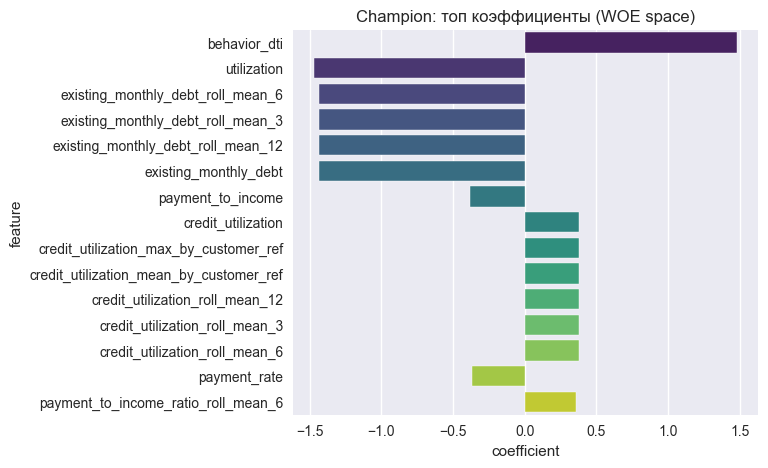

Reason codes sample:


[{'row': 0,
  'index': 44325,
  'factors': [{'feature': 'existing_monthly_debt_roll_mean_3',
    'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt', 'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt_roll_mean_12',
    'contribution': -0.5902707770462797}]},
 {'row': 1,
  'index': 81175,
  'factors': [{'feature': 'existing_monthly_debt',
    'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt_roll_mean_12',
    'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt_roll_mean_3',
    'contribution': -0.5902707770462797}]},
 {'row': 2,
  'index': 44327,
  'factors': [{'feature': 'existing_monthly_debt',
    'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt_roll_mean_12',
    'contribution': -0.5902707770462797},
   {'feature': 'existing_monthly_debt_roll_mean_3',
    'contribution': -0.5902707770462797}]},
 {'row': 3,
  'index': 571,
  'factors': [{'feature': 'existin

,feature,mean_abs_shap
0,monthly_free_cash_flow_roll_mean_6,0.076408
1,monthly_free_cash_flow_roll_mean_12,0.074860
2,credit_score_mean_hist_roll_mean_6,0.052998
3,credit_score_max_hist_roll_mean_12,0.051304
4,monthly_free_cash_flow_roll_mean_3,0.050921
5,credit_score_mean_hist,0.048406
6,credit_score_min_hist_roll_mean_12,0.048014
7,credit_score_max_hist_roll_mean_3,0.046017
8,credit_score_max_hist,0.044940
9,credit_score_mean_hist_roll_mean_12,0.044678


/tmp/ipykernel_272267/2709578010.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shap_df, x=value_col, y="feature", palette="mako")


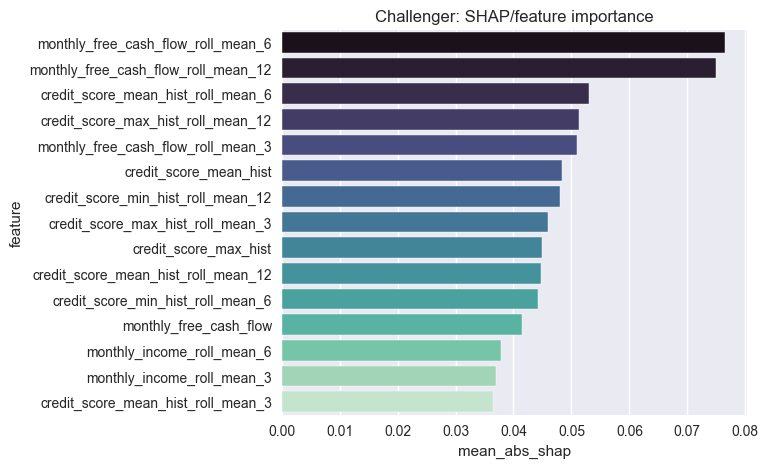

In [14]:
champion_coefs = pd.DataFrame(champion_coefficients(champion_model))
champion_coefs["abs_coef"] = champion_coefs["coefficient"].abs()
champion_top = champion_coefs.sort_values("abs_coef", ascending=False).head(15)
display(champion_top)

plt.figure(figsize=(6, 5))
sns.barplot(data=champion_top, x="coefficient", y="feature", palette="viridis")
plt.title("Champion: топ коэффициенты (WOE space)")
plt.show()

champion_explain_path = artifacts_dir / "champion_explainability.json"
if champion_explain_path.exists():
    with open(champion_explain_path, "r", encoding="utf-8") as fh:
        champion_explain = json.load(fh)
    print("Reason codes sample:")
    display(champion_explain.get("reason_codes", [])[:5])

shap_path = artifacts_dir / "challenger_shap.json"
if shap_path.exists():
    with open(shap_path, "r", encoding="utf-8") as fh:
        shap_payload = json.load(fh)
    shap_df = pd.DataFrame(shap_payload.get("feature_importance", [])).head(15)
    if not shap_df.empty:
        display(shap_df)
        value_col = [col for col in shap_df.columns if col != "feature"][0]
        plt.figure(figsize=(6, 5))
        sns.barplot(data=shap_df, x=value_col, y="feature", palette="mako")
        plt.title("Challenger: SHAP/feature importance")
        plt.show()
else:
    print("SHAP артефакт не найден — возможно, challenger не обучался в предыдущем run")